In [7]:
import os
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv

In [8]:
load_dotenv()

True

In [9]:
@tool
def random_got_quote_tool()->Dict:
    """
    Return a random Game of Thrones quote and the character who said it
    """
    response = requests.get("https://api.gameofthronesquotes.xyz/v1/random")
    return response.json()

In [10]:
random_got_quote_tool.invoke({})

{'sentence': 'There is only one war that matters. The Great War. And it is here.',
 'character': {'name': 'Jon Snow',
  'slug': 'jon',
  'house': {'name': 'House Stark of Winterfell', 'slug': 'stark'}}}

In [11]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY")
)

In [12]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    response = tavily_client.search(question)
    return response

In [13]:
web_search.invoke(
    {
        "question": "Who performs Cersei Lannister in Game of Thrones?"
    }
)

{'query': 'Who performs Cersei Lannister in Game of Thrones?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://gameofthrones.fandom.com/wiki/Lena_Headey',
   'title': 'Lena Headey - Wiki of Westeros - Fandom',
   'content': 'Lena Kathren Headey (born 3 October 1973) is a Bermudan-English actress, who plays Queen Cersei Lannister in Game of Thrones.',
   'score': 0.90985113,
   'raw_content': None},
  {'url': 'https://www.facebook.com/groups/GameofScenes/posts/2403333756522770/',
   'title': "Lena Headey's Performance as Cersei Lannister in Game of Thrones",
   'content': "Currently doing a rewatch and I gotta say Lena Headey's performance as Cersei Lannister is my favorite and honestly the most unforgettable from",
   'score': 0.852752,
   'raw_content': None},
  {'url': 'https://www.televisionacademy.com/bios/lena-headey',
   'title': 'Lena Headey | Television Academy',
   'content': 'Lena Headey is a British actress who currently stars as C

In [14]:
tools = [random_got_quote_tool, web_search]

In [16]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=os.getenv("OPEN_AI_API_KEY")
)

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [28]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [29]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


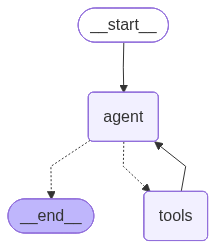

In [30]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [31]:
messages = [
    SystemMessage(
        "You are a Web Researcher focused on Game of Thrones. "
        "If user asks you a random quote about GoT. You will not only " 
        "provide it, but also search the web to find the actor or actress "
        "who perform the character who said that."
        "So, your output should be: Quote, Character and Performer."
    ),
    HumanMessage("Give me a radom GoT quote")
]

In [32]:
result = graph.invoke(
    input={
        "messages": messages
    }
)

print(result)

{'messages': [SystemMessage(content='You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.', additional_kwargs={}, response_metadata={}, id='84bafb34-9795-49a9-9691-b8cce73f442d'), HumanMessage(content='Give me a radom GoT quote', additional_kwargs={}, response_metadata={}, id='c3046ecc-2cec-442a-90ed-818ed9a80032'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2M4B4NuGROU7bbeXc6VA17W8', 'function': {'arguments': '{}', 'name': 'random_got_quote_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 141, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

In [33]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a Web Researcher focused on Game of Thrones. If user asks you a random quote about GoT. You will not only provide it, but also search the web to find the actor or actress who perform the character who said that.So, your output should be: Quote, Character and Performer.
================================ Human Message =================================

Give me a radom GoT quote
================================== Ai Message ==================================
Tool Calls:
  random_got_quote_tool (call_2M4B4NuGROU7bbeXc6VA17W8)
 Call ID: call_2M4B4NuGROU7bbeXc6VA17W8
  Args:
================================= Tool Message =================================
Name: random_got_quote_tool

{"sentence": "Every man must die, Jon Snow. but first, he must live", "character": {"name": "Ygritte", "slug": "ygritte", "house": {"name": null, "slug": null}}}
================================== Ai Message =================